

> Блок с отступами



**Цель** -  выявить идентичность российского ВУЗа через анализ языковых средств в текстах новостей на сайте.

**Исследовательский вопрос**:

Как идентичность проявляется в тех текстах, которые публикуются на сайтах вузов

**Задачи**:

1. Составить перечень ВУЗов, с сайтами которых будем работать (10 вузов разной направленности: политех, спортивный вуз, медицинский,классический...)
2. Отобрать из датасета, подготовленного с коллегами во время проекта Приоритет-2030, новости с вебсайтов 10 ВУЗов.
3. Сделать дополнительный парсинг, если не хватает новостей.
4. Предобработать данные.
5. Сделать тематическое моделирование (LDA) **в общем и для каждого ВУЗа в отдельности** - 5-7 кластеров по 15 слов.
6. Выявить общие темы для современного ВУЗА.
7. Выявить специфические темы для каждого из ВУЗов.
8. Найти оптимальные значения параметров (количесвто кластеров, ключевых слов)
9. Проанализировать частотные 2-граммы или 4-граммы для уточнения названия кластеров.
10. Сделать визуализацию в R для полученных данных

Перспективы работы

11. Сделать синтаксическую разметку текстов.
12. Найти триплеты - подлежащее, сказумое и дополнение?
13. Сделать анализ контекстов справа и слева - конкордансы.


**Материал исследования** - тексты, размещенные на сайтах российских ВУЗов на русском языке.

Пайплайн

1. Сбор материала с вебсайтов 10 вузов по 20-100 новостных текстов с каждого (готовый датасет в txt + Скрейпинг новых - requests)
2. Загрузка данных в датафрейм (pandas)
Создание общего корпуса (всех вузов) и подкорпусов (каждого в отдельности).
3. Токенизация и лемматизация текстов (pymorphy)
4. Выявление ключевых слов (tfidf)
5. Кластеризация подкорпусов (LDA)
6. Синтаксическая разметка (pymorphy или Natasha)
7. Анализ левого и правого контекста с названием или аббревиатурой ВУЗа (актор/действие)

**Перечень вебсайтов ВУЗов**

Классические университеты ТГУ, СПбГУ, БФУ

Технические многопрофильные университеты ТПУ, СПбПУ, БГТУ

Медицинские и фармацевтические вузы САМГМУ

Военные вузы и вузы силового блока ВАС

Транспортные вузы ДВГУПС

Спортивные ВУЗы СибСпорт, Ун. Лесгафта







In [ ]:
# Загрузка документов с Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ИМПОРТ БИБЛИОТЕК

In [ ]:
#@title Импорт библиотек
import os
import pandas as pd
from nltk import word_tokenize

import nltk
nltk.download('punkt')

from nltk.tokenize import WordPunctTokenizer

nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('russian')

import string

!pip install pymorphy2
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np

from sklearn.decomposition import LatentDirichletAllocation

!pip install pyldavis

import pyLDAvis
#import pyLDAvis.sklearn

import matplotlib.pyplot as plt
import seaborn as sns

РАСПРЕДЕЛЕНИЕ УНИВЕРСИТЕТОВ ПО ГРУППАМ

In [ ]:
uni_types = {"classic": ["СПбГУ news_events", "БФУ", "ТГУ tsu_news"],
             "tech": ["ТПУ", "СПбПУ", "БГТУ"],
             "med": ["СамГМУ"],
             "milit": ["ВАС"],
             "sport": ["СибСпорт", "Ун. Лесгафта"],
             "transport": ["ДВГУПС"]}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ФУНКЦИЯ ДЛЯ СБОРА ДАННЫХ

In [ ]:
def get_data():
    corpus = []
    universities = []
    type_uni = []
    dirpath = '/content/drive/MyDrive/КЛ ФПК/тексты_ВУЗы'
    for filename in os.listdir(dirpath):
        new_path = dirpath+ "/" + filename
        type_ = [k for k, v in uni_types.items() if filename in v][0]
        print(type_)
        for new_filename in os.listdir(new_path):
            if new_filename.endswith("data.txt"):
                text_path = new_path + "/" + new_filename
                with open (text_path, 'r', encoding = 'utf-8') as f:
                    text = f.read()
                    corpus.append(text)
                    universities.append(filename)
                    type_uni.append(type_)
    return corpus, universities, type_uni

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
corpus, universities, type_uni = get_data()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


classic
sport
classic
tech
sport
tech
med
transport
classic
milit


In [ ]:
print(len(corpus)) # корпус текстов
len(universities) # перечень назвний университетов

424


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


424

СОЗДАНИЕ ТАБЛИЦ

In [ ]:
df = pd.DataFrame()
df["text"] = corpus
df["uni"] = universities
df["uni_type"] = type_uni

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ПРОВЕРКА ТАБЛИЦЫ

In [ ]:
df.sample(5) # несколько рандомных элементов таблицы

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,uni,uni_type
32,22 мая на территории Российской Федерации в 9:...,СибСпорт,sport
250,"В XX веке советская власть, сама того не желая...",СПбПУ,tech
63,"В этот день, 27 апреля, ровно 72 года назад, п...",СибСпорт,sport
209,Наш новый герой проекта «Дай пять» работает в ...,СПбПУ,tech
249,"«Здесь есть море возможностей», – говорит о на...",СПбПУ,tech


## ПРЕДОБРАБОТКА ДАННЫХ

In [ ]:
# функция для токенизации и лемматизации текстовых данных

def preprocess_data(text):
    text = text.lower()
    text_tokens = WordPunctTokenizer().tokenize(text)
    spec_chars = string.punctuation + '\n\xa0«»\t—...'
    text_tokens = [token for token in text_tokens if
                   (token not in stopwords and token not in spec_chars and not any(char.isdigit() for char in token))]

    text_lemmatized = [morph.parse(token)[0].normal_form for token in text_tokens]

    return " ".join(text_lemmatized)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# добавляем столбец в датафрейм

df["clean_text"] = df["text"].apply(preprocess_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
 # проверяем рандомно, какая таблица получилась

 df.sample(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,uni,uni_type,clean_text
159,31 марта Политехнический университет посетила...,СПбПУ,tech,март политехнический университет посетить деле...
377,В Санкт-Петербурге состоялся региональный этап...,СПбГУ news_events,classic,санкт петербург состояться региональный этап в...
166,Герой очередного выпуска спецпроекта «Наукогр...,СПбПУ,tech,герой очередной выпуск спецпроект наукоград ос...
127,"Сегодня, 30 июня 2022 года, наш вуз заключил е...",Ун. Лесгафта,sport,сегодня июнь год наш вуз заключить важный дого...
5,\nПравительство России приняло во внимание одн...,ТГУ tsu_news,classic,правительство россия принять внимание один клю...


## Кластеризация для всех университетов

### ВЕКТОРИЗАЦИЯ

In [ ]:
# векторизуем слова
# приводим к типу данных "Список"
# извлекаем ключевые слова

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1)) # только униграммы (когда указываем, например 1,4 через запятую, то весь диапазон на выходе)
tfidf = tfidf_vectorizer.fit_transform(df["clean_text"].tolist())
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# создаем функцию для извлечения ключевых слов, top_n - нужное количество ключевых слов

def get_top_tf_idf_words(text, tfidf_vectorizer, feature_names, top_n):
    tfidf_vector = tfidf_vectorizer.transform([text])
    sorted_nzs = np.argsort(tfidf_vector.data)[:-(top_n+1):-1]
    return feature_names[tfidf_vector.indices[sorted_nzs]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ЗАГРУЗКА КЛЮЧЕВЫХ СЛОВ ДЛЯ КАЖДОГО ВУЗА? В ТАБЛИЦУ

In [ ]:
# добавляем ключевые слова (в данном случае 20 слов) для каждого? текста в готовую таблицу

df["top_words"] = df["clean_text"].apply(get_top_tf_idf_words, tfidf_vectorizer = tfidf_vectorizer, feature_names = feature_names, top_n = 20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# df['top_words'] = df['clean_text'].apply(lambda x: get_top_tf_idf_words(x, tfidf_vectorizer, feature_names, 20))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# проверяем, правильно ли загружены данные

df.sample(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,uni,uni_type,clean_text,top_words
61,В минувшие выходные в зале спортивных игр СибГ...,СибСпорт,sport,минувший выходной зал спортивный игра сибгуфк ...,"[курс, сборная, турнир, команда, омский, волей..."
148,Наш новый герой проекта «Дай пять» работает в ...,СПбПУ,tech,наш новый герой проект дать пять работать науч...,"[волоконный, квантовый, оптический, лекция, оп..."
100,Ученые БФУ им. И. Канта с коллегами из Институ...,БФУ,classic,учёный бфу кант коллега институт океанология п...,"[вода, океан, раковина, климатический, изменен..."
10,\nПочему критическое мышление так важно для со...,ТГУ tsu_news,classic,почему критический мышление важно современный ...,"[мышление, критический, bani, интуиция, эколог..."
30,"Сегодня, 19 мая, отмечает День рождения Минист...",СибСпорт,sport,сегодня май отмечать день рождение министр спо...,"[спорт, олег, федерация, матыцин, член, россий..."


In [ ]:
# сохраняем в формате csv и убираем первый столбец с индексом

df.to_csv("corpus_n-grams.csv", index = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# сохраняем в формате csv на гугл диск??

# df.to_scv(/content/corpus_n-grams.csv)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### LDA

In [ ]:
# создаем модель LDA для кластеризации тем текстов одного типа ВУЗов без учителя
# р7 топиков (кластеров), итреаций - 10, ??

lda = LatentDirichletAllocation(n_components=7, max_iter=10,learning_offset=10)

lda.fit(tfidf)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(learning_offset=10, n_components=7)

In [ ]:
# подбираем параметры для визуализации данных, чтобы удобно было анализировать

def plot_top_words(model, feature_names, n_top_words, title):

    fig, axes = plt.subplots(7, 1, figsize=(30, 100)) # параметры отображения # 7строки по 1 столбцов
    axes = axes.flatten()
    all_features = {} # словарь для сохранения ключевых слов для тем

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        # строка для сохранения темы и слов в словарь

        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


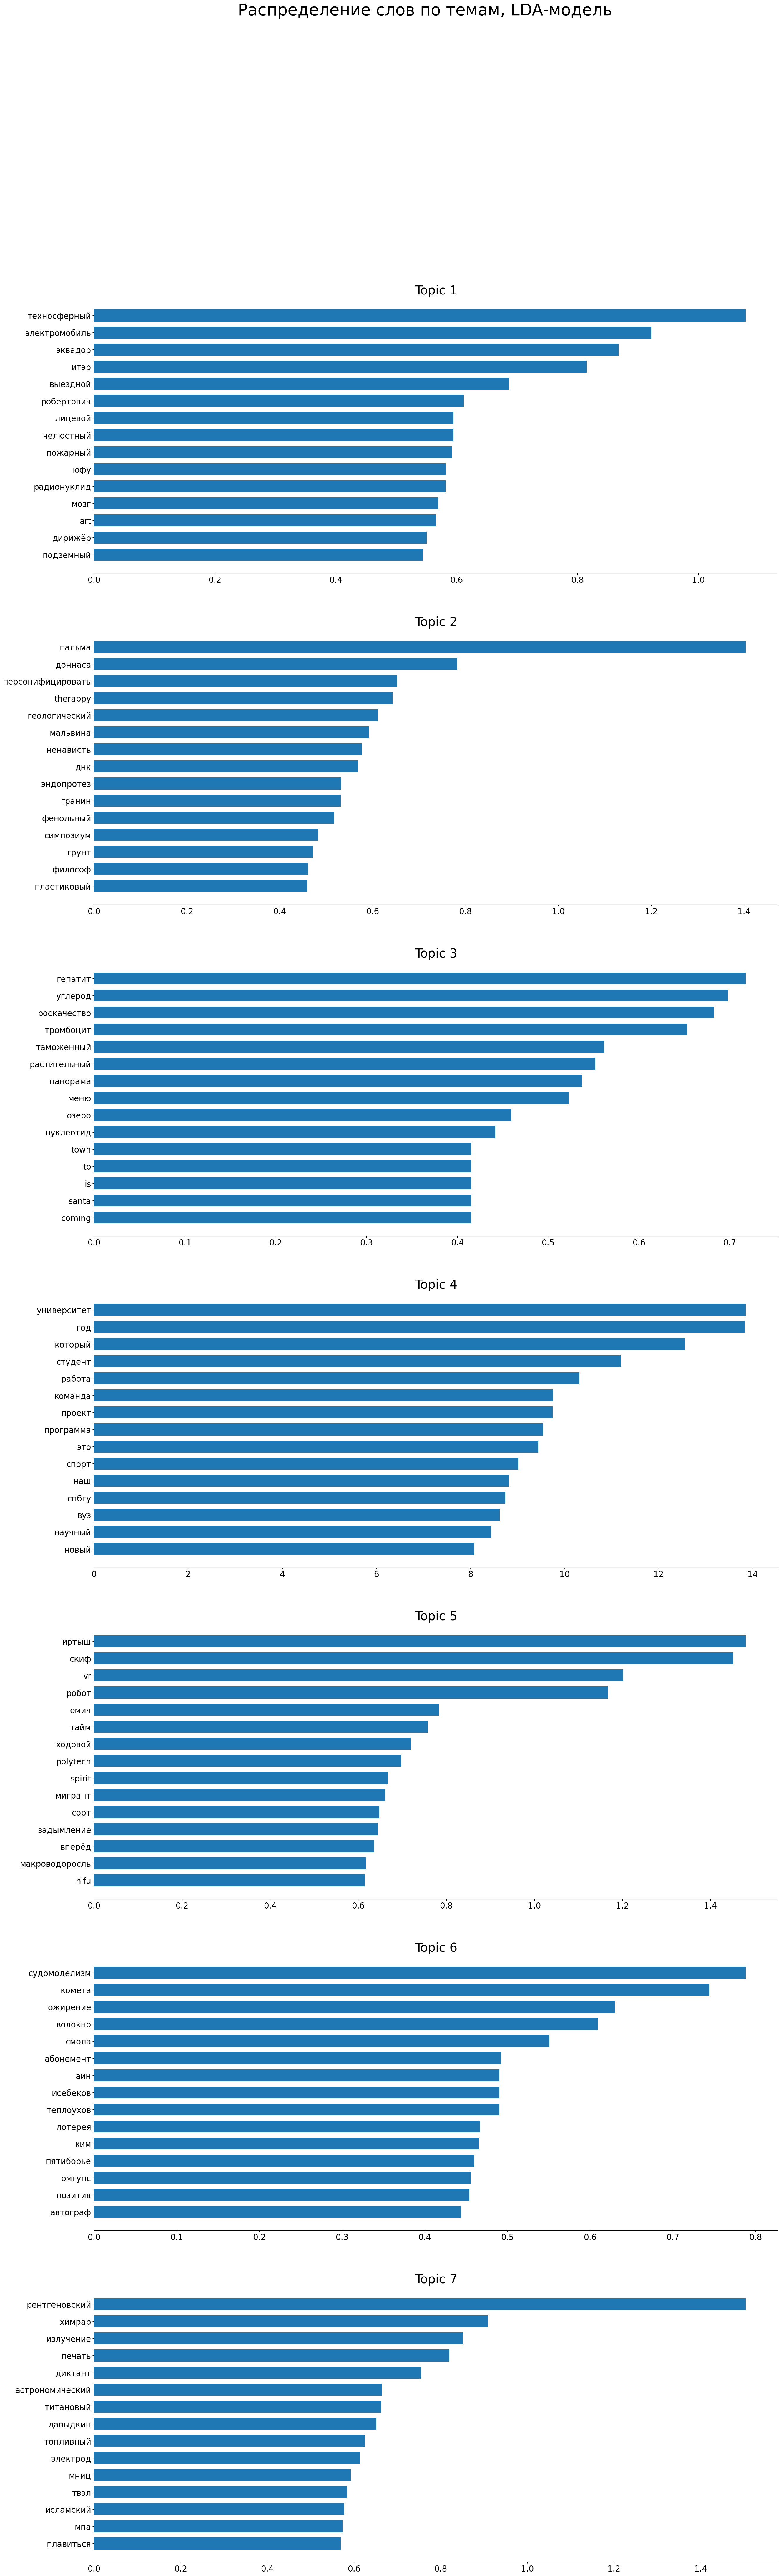

In [ ]:
# распределяем по 7 тем и 15 ключевых слов
# вписываем названия
# это мы сделали для всех текстов???

tf_feature_names = tfidf_vectorizer.get_feature_names_out()

plot_top_words(lda, tf_feature_names, 15,'Распределение слов по темам, LDA-модель')

## Кластеризация (LDA) для разных типов университетов

In [ ]:
# df.to_csv("corpus.csv", index = False) # чтобы не было первого столбца с индексом

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# создаем табличку с перечнем ключевых слов по топикам

df_unitype_topics = pd.DataFrame(columns = ["Unitype", "Topic_words"])

# берем униграммы и биграммы
for unitype in uni_types:
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
    tfidf = tfidf_vectorizer.fit_transform(df[df["uni_type"] == unitype]["clean_text"].tolist())
    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

    lda = LatentDirichletAllocation(n_components=7, max_iter=10,learning_offset=10)
    lda.fit(tfidf)

# извлекаем 15 ключевых слов
    n_top_words = 15
    for topic_idx, topic in enumerate(lda.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        dict_topics = {"Unitype": unitype, "Topic_words": top_features}
        df_unitype_topics = df_unitype_topics.append(dict_topics, ignore_index = True)

In [ ]:
df_unitype_topics.sample()

In [ ]:
df_unitype_topics.to_csv("/content/drive/MyDrive/КЛ ФПК/unitype_topics.csv")

In [ ]:
df.to_csv("/content/drive/MyDrive/КЛ ФПК/clean_text+top_words.csv")

На данном этапе работы показано, что лучше всего анализ ключевых слов (по TfIdf)

Модели LDA, Rake, Yake также можно исполозовать

при установке следующих параметров - 7 кластеров, 15 ключевых слов LDA - 5 тем из 7 хорошо интерпретируются.

При кластеризации всех ВУЗов только 2 из 7 тем интерпретируемы, однако одна из тем полностью покрывает темы, выделенные нами для разных университетов.

Дополнительные файлы в репозитории:

Файл с вк

Файл со скрейпингом более актуальных новостей

Файл с Rake и Yake

##ПЕРСПЕКТИВЫ РАБОТЫ

КОНКОРДАНС

In [ ]:
# надо?

import nltk
nltk.download('gutenberg')

from nltk.text import Text
from nltk.corpus import gutenberg
corpus = gutenberg.words('/content/drive/MyDrive/КЛ ФПК/тексты_ВУЗы/СПбПУ/0_data.txt')
# corpus = (" ".join(df[df["uni"] == "СПбПУ"]["text"].tolist())).split(" ")
text = Text(corpus)

text.concordance("чемпионка")

In [ ]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,uni,uni_type,clean_text,top_words
0,\nНациональный исследовательский Томский госуд...,ТГУ tsu_news,classic,национальный исследовательский томский государ...,"[форум, талант, mail, tsu, ru, тгу, профориент..."
1,\nВ условиях санкционного давления промышленно...,ТГУ tsu_news,classic,условие санкционный давление промышленность ро...,"[малотоннажный, химия, продукт, предприятие, к..."
2,\nКоманда студентов факультета психологии Томс...,ТГУ tsu_news,classic,команда студент факультет психология томский г...,"[фестиваль, реклама, команда, тгу, ярпиар, оли..."
3,\nФилологический факультет Томского государств...,ТГУ tsu_news,classic,филологический факультет томский государственн...,"[электронный, медиа, тгу, литература, современ..."
4,\nПроцесс таяния вечной мерзлоты приводит к вы...,ТГУ tsu_news,classic,процесс таяние вечный мерзлота приводить высво...,"[углерод, озеро, термокарстовый, органический,..."


In [ ]:
# будем работать с типом данных "Текст"
# будем анализировать в окружении каких слов встречаются слова-названия университетов

from nltk.text import Text
corpus = (df[df["uni"] == "СПбПУ"]["clean_text"].values[0]).split()
print(corpus)

['санкт', 'петербургский', 'государственный', 'симфонический', 'оркестр', 'классика', '»,', 'постоянный', 'участник', 'концертный', 'программа', 'белый', 'зал', 'спбп', 'март', 'дать', 'большой', 'концерт', 'память', 'даниил', 'гранин', 'выпускник', 'политех', 'стать', 'писатель', 'общественный', 'деятель', 'лауреат', 'множество', 'государственный', 'премия', 'звание', 'даниил', 'гранин', 'жизнь', 'представлять', 'себя', 'целый', 'эпоха', 'год', 'окончить', 'лпи', 'специальность', 'гидроэлектрический', 'станция', 'квалификация', 'инженер', 'электрика', 'роман', 'учёный', 'физик', 'идти', 'гроза', 'стать', 'прорывный', 'явление', 'литература', 'блокадный', 'книга', '»,', 'написать', 'соавторство', 'алесь', 'адамович', 'открыть', 'мир', 'исторический', 'правда', 'страшный', 'день', 'блокада', 'наш', 'город', 'даниил', 'гранин', 'очень', 'ценить', 'живой', 'общение', 'живой', 'музыка', 'постоянный', 'слушатель', 'оркестр', 'классика', '».', 'сохраниться', 'видеофрагмент', 'который', 'дани

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# ищем название вуза (например, СПбПУ)

text = Text(corpus)
text.concordance("классика")

Displaying 3 of 3 matches:
ударственный симфонический оркестр классика », постоянный участник концертный 
узыка постоянный слушатель оркестр классика ». сохраниться видеофрагмент котор
л гранин пожелать именно оркестр „ классика “ участвовать торжество большой за


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# СИНТАКСИЧЕСКИЙ ПАРСИНГ ДЛЯ АНАЛИЗА ЛЕВОГО И ПРАВОГО КОНТЕКСТА


In [ ]:
# синтаксическая разметка

!pip install natasha

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26099 sha256=eeeaa04b096140a3d005bc9eac2377eaca6fa78f9ead9de11e92b8414cf16491
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree


In [ ]:
# синтаксический парсинг - визуализация зависимостей

from natasha import Doc, NewsEmbedding,NewsSyntaxParser,Segmenter


emb = NewsEmbedding()
syntax_parser = NewsSyntaxParser(emb)
segmenter = Segmenter()

doc = Doc(" ".join(corpus))
doc.segment(segmenter)
print(doc)
doc.parse_syntax(syntax_parser)
print(doc.tokens[:5])
doc.sents[0].syntax.print()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Doc(text='санкт петербургский государственный симфонический..., tokens=[...], sents=[...])
[DocToken(stop=5, text='санкт', id='1_1', head_id='1_169', rel='obl'), DocToken(start=6, stop=19, text='петербургский', id='1_2', head_id='1_29', rel='amod'), DocToken(start=20, stop=35, text='государственный', id='1_3', head_id='1_29', rel='amod'), DocToken(start=36, stop=49, text='симфонический', id='1_4', head_id='1_5', rel='amod'), DocToken(start=50, stop=57, text='оркестр', id='1_5', head_id='1_149', rel='nmod')]
                        ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────► санкт              obl
                        │                                                                                                                                                                                                      

In [ ]:
emb = NewsEmbedding()
syntax_parser = NewsSyntaxParser(emb)
segmenter = Segmenter()

doc = Doc(" ".join(text))
doc.segment(segmenter)
print(doc)
doc.parse_syntax(syntax_parser)
print(doc.tokens[:5])
doc.sents[0].syntax.print()

Как вытащить зависимости?

Что сначала? Конкорданс или парсинг?

Не вытаскивается название ВУЗа

Что можно и как визуалилзировать в R?
